# Random Florest (Scikit-learn)

# 0 Importação

In [1]:
import os
import glob
import time
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, log_loss,
    classification_report, confusion_matrix
)

In [3]:
SEED_VALUE = 42

# Fix seed to make training deterministic.
np.random.seed(SEED_VALUE)

# 1 Configurações

In [4]:
image_size = (64, 64)
dataset_path = "./datasets/Plastic_Classification"
os.makedirs("models/03_random_forest", exist_ok=True)

# 2 Função de Carregamento

In [5]:
def carregar_imagens(pasta, image_size=(64, 64)):
    X, y = [], []
    for classe in sorted(os.listdir(pasta)):
        caminho_classe = os.path.join(pasta, classe)
        if not os.path.isdir(caminho_classe):
            continue
        for arquivo in glob.glob(os.path.join(caminho_classe, "*.jpg")):
            img = cv2.imread(arquivo, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, image_size)
            X.append(img.flatten() / 255.0)
            y.append(classe)
    return np.array(X), np.array(y)

# 3 Pré-processamento

In [6]:
X_train, y_train = carregar_imagens(os.path.join(dataset_path, "train"))
X_val, y_val = carregar_imagens(os.path.join(dataset_path, "validation"))
X_test, y_test = carregar_imagens(os.path.join(dataset_path, "test"))

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)


# 4 Treinamento do modelo

In [7]:
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

start_train = time.time()
model.fit(X_train, y_train_enc)
train_time = time.time() - start_train

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    8.5s finished


# 5 Avaliação

In [8]:
start_pred = time.time()
y_pred = model.predict(X_test)
inference_time = (time.time() - start_pred) / len(X_test)

# Previsão de probabilidade (para log_loss)
y_proba = model.predict_proba(X_test)

acc = accuracy_score(y_test_enc, y_pred)
f1 = f1_score(y_test_enc, y_pred, average="weighted")
loss = log_loss(y_test_enc, y_proba)

print(f"\n🧰 Tempo de treino: {train_time:.2f}s")
print(f"⚡ Tempo de inferência (por imagem): {inference_time*1000:.2f} ms")
print(f"✅ Acurácia: {acc:.4f}")
print(f"🎯 F1-score ponderado: {f1:.4f}")
print(f"📉 Log Loss: {loss:.4f}\n")
print("📋 Classification Report:\n")
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.0s finished



🧰 Tempo de treino: 8.77s
⚡ Tempo de inferência (por imagem): 0.67 ms
✅ Acurácia: 0.3780
🎯 F1-score ponderado: 0.3452
📉 Log Loss: 1.7160

📋 Classification Report:

              precision    recall  f1-score   support

        HDPE       0.08      0.07      0.07        30
        LDPA       0.56      0.60      0.58        30
       Other       0.00      0.00      0.00        30
         PET       0.64      0.31      0.42        29
          PP       0.60      0.90      0.72        30
          PS       0.36      0.53      0.43        30
         PVC       0.17      0.23      0.19        30

    accuracy                           0.38       209
   macro avg       0.35      0.38      0.35       209
weighted avg       0.34      0.38      0.35       209



# 6 Matriz de confusão

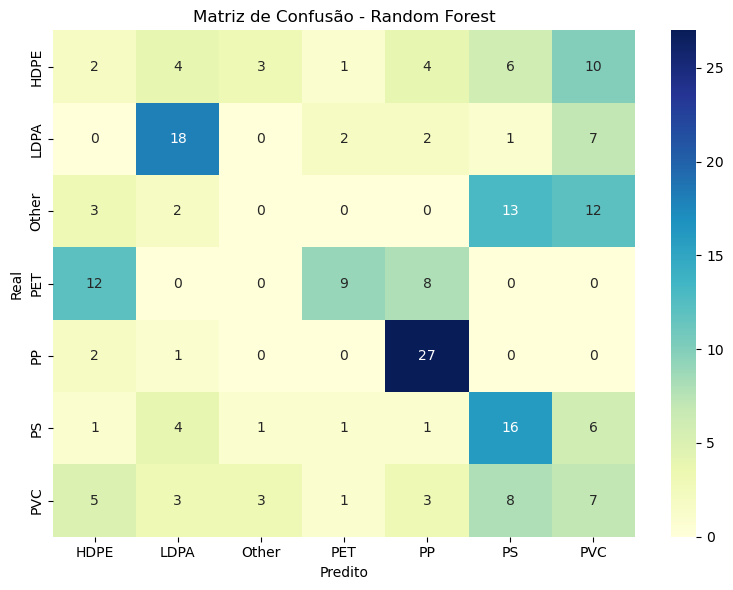

In [10]:
cm = confusion_matrix(y_test_enc, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Matriz de Confusão - Random Forest")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# 7 Previsão 

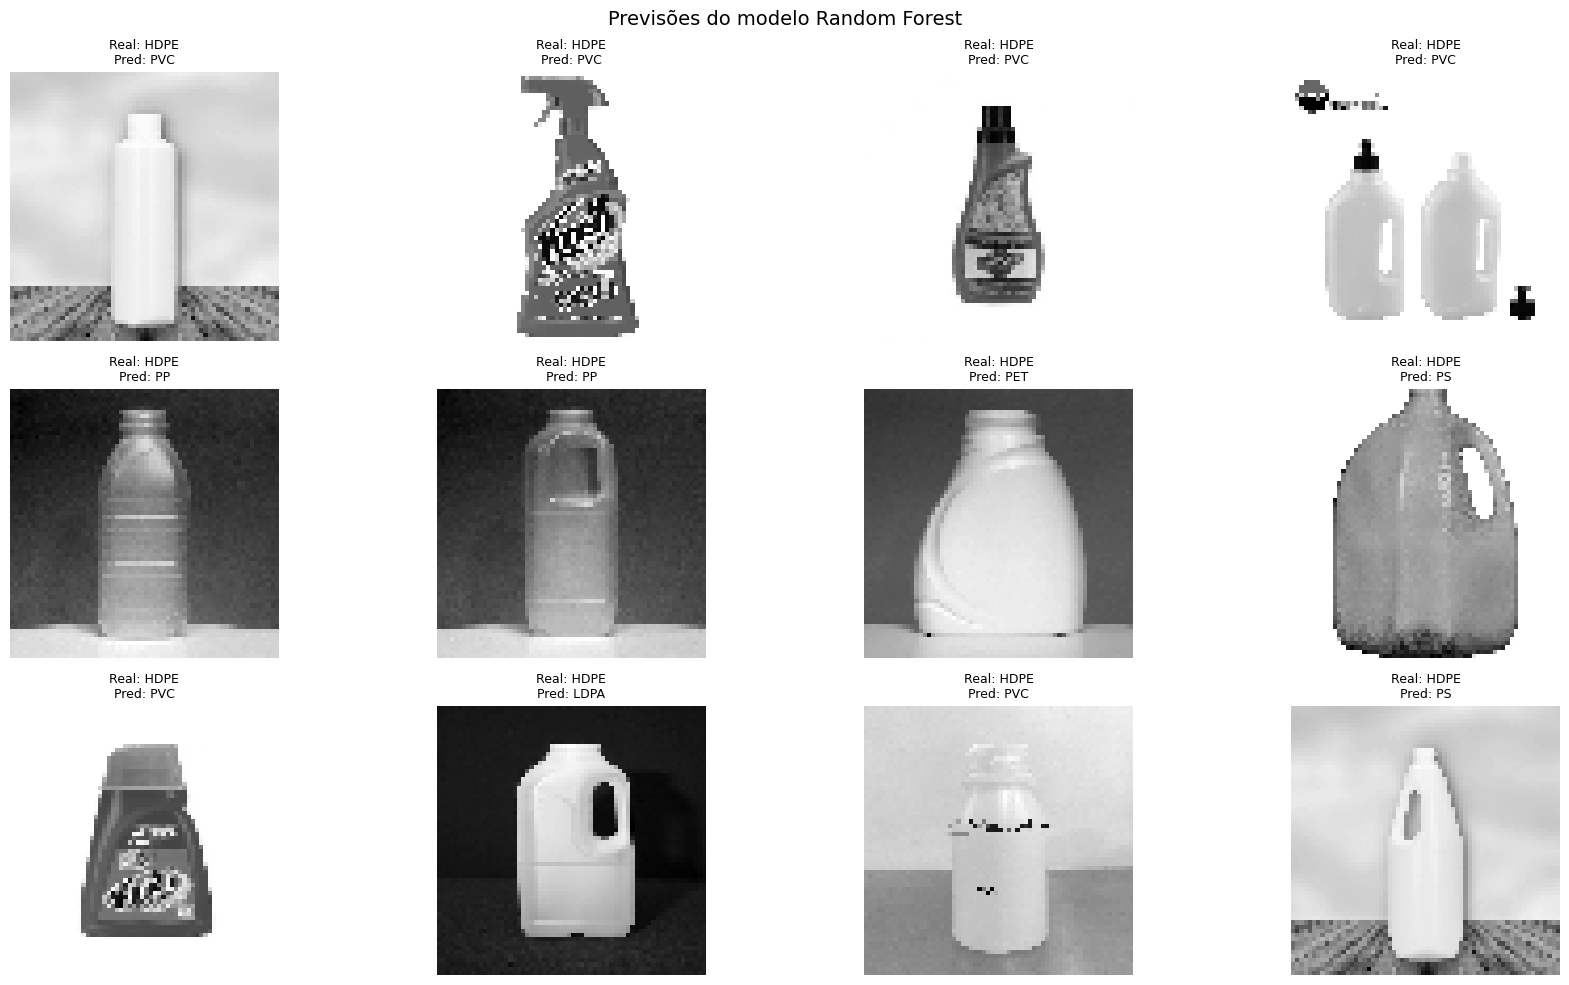

In [13]:
X_test_imgs = X_test.reshape((-1, 64, 64)) * 255.0
real_labels = le.inverse_transform(y_test_enc)
pred_labels = le.inverse_transform(y_pred)

plt.figure(figsize=(18, 10))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(X_test_imgs[i], cmap="gray")
    plt.axis("off")
    plt.title(f"Real: {real_labels[i]}\nPred: {pred_labels[i]}", fontsize=9)
plt.suptitle("Previsões do modelo Random Forest", fontsize=14)
plt.tight_layout()
plt.show()

# 8 Salvar o modelo e as metricas


In [14]:
joblib.dump(model, "models/03_random_forest/random_forest_model.joblib")
joblib.dump(le, "models/03_random_forest/label_encoder_random_forest.joblib")

with open("models/03_random_forest/random_forest_metrics.json", "w") as f:
    json.dump({
        "model": "Random Forest",
        "accuracy": acc,
        "f1_score_weighted": f1,
        "log_loss": loss,
        "train_time_sec": train_time,
        "inference_time_ms": inference_time * 1000
    }, f, indent=4)
    
joblib.dump((X_test, y_test), "models/test_data_for_comparisons.joblib")
print("✅ Dados de teste salvos com sucesso.")

✅ Dados de teste salvos com sucesso.
